# ECEN743 Spring 2024 - Assignment 2
## Tabular RL Algorithms

In this assignment, you will solve the FrozenLake-v0 environment from [Gymnasium](https://gymnasium.farama.org/). You will be using this helper file to answer questions in your assignment. 

**Note that you do not need to start from the scratch. Only write your code between the following lines. Do not modify other parts.**  
"### YOUR CODE HERE"  
"### END OF YOUR CODE"

## Introduction of the FrozenLake Environment

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake. The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment. Holes in the ice are distributed in set locations using a pre-determined map, and the player makes moves until they reach the goal or fall in a hole. The map is given below for your reference

        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
    
### Action Space
The player/agent can take 4 discrete actions, in the range {0,3}
* 0: Move left
* 1: Move down
* 2: Move right 
* 4: Move up


### State Space
The environment consists of 16 states. The state is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).
For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.


### Starting State
The episode starts with the player in state [0] (location [0, 0]).


### Rewards 

* Reach goal: +1
* Reach hole: 0
* Reach frozen: 0

### Episode End
The episode ends if the following happens:
#### 1.Termination:
* The player moves into a hole.
* The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).

#### 2.Truncation:
* The length of the episode is 100 for 4x4 environment.

For more info refer to source: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

### The Environment Parameters
* Use discount factor, $\gamma = 0.9$
* The environment is slippery, ie., the transition kernel is stochastic.
* The transition kernel P is a dictionary. 
* P[state][action] is tuples with (probability, nextstate, reward, terminal)

**Run the following initializer. Make sure you can execute it without any error.**

If you wish to finish this assignment using Google Colab. Uncomment the following commands and run them.

In [3]:
# !pip install swig
# !pip install gymnasium[box2d]

In [22]:
import gymnasium as gym
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
np.set_printoptions(precision=4, suppress=True)

env = gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=True)
gamma = 0.9


def fancy_visual(value_func,policy_int):    
    grid = 4    
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap="icefire",vmax=1.1, robust = True,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()

# The optimal Q-value function from HW01
Q_opt = np.array([[0.06887237, 0.06663045, 0.06663045, 0.05974078],
                 [0.03907988, 0.04297989, 0.04073797, 0.06139887],
                 [0.07439831, 0.06881719, 0.0727172,  0.05747583],
                 [0.03905686, 0.03905686, 0.03347574, 0.05579473],
                 [0.09183769, 0.07117679, 0.06428712, 0.04821147],
                 [0.,         0.,         0.,         0.        ],
                 [0.11220205, 0.08988305, 0.11220205, 0.02231899],
                 [0.,         0.,         0.,         0.        ],
                 [0.07117679, 0.11787214, 0.1017965,  0.14542271],
                 [0.15760471, 0.24748776, 0.20386154, 0.13350927],
                 [0.29961112, 0.26595078, 0.22536519, 0.10790627],
                 [0.,         0.,         0.,         0.        ],
                 [0.,         0.,         0.,         0.        ],
                 [0.18822442, 0.30568334, 0.37992926, 0.26595078],
                 [0.39556639, 0.63901667, 0.61492124, 0.53719488],
                 [0.,         0.,         0.,         0.        ]])

## 1. Tabular Q-Learning

### The decay of learning rate and exploration factor
We aim to learn the optimal Q-value function through online exploration. Intuitively, after sufficient exploration, our learner should already have good amount of awareness in the scary FrozenLake. Too much exploration results in a sub-optimal policy. Hence, we should dynamically adjust our exploration scheme.

The convergence of an online learning algorithm is highly correlated to the stochasticity of the environment. As a result, you may see your Q-value function fluctuates frequently. This could be because the learner just faced a bad episode! However, after training for a while, your learner should have seen sufficient number of both good and bad episodes. Decaying the learning rate can help the algorithm to converge to the optimal policy.

### Your Task
1. Implement `lr_decay` and `epsilon_decay`. Experiment with linear decay, exponential decay, etc. You do not need to find **THE** best decay scheme.
2. Implement `epsilon_greedy'. One way to do this is to sample a Bernoulli random variable with parameter $\epsilon$. Note that, $\epsilon$ is the probability that **you choose a random action instead of the greedy action**.
3. Implement Q-Learning update.

In [106]:
def lr_decay(k, max_episodes=30000):
    """Return the learning rate for k-th episode

    Args:
        k: The index of episode.
    Returns:
        lr: The learning rate for this episode.
    """
    ### YOUR CODE HERE
    # TASK 1
    lr = 0.5
    min_lr = 0.01
    decay_factor = min(1.0, (k+1) / (max_episodes / 2))
    lr = lr * (1 - decay_factor) + min_lr * decay_factor
    ### END OF YOUR CODE
    return lr

def epsilon_decay(k, max_episodes=30000):
    """Return the decayed exploration factor
    
    Args:
        k: The index of episode.
    Returns:
        epsilon: The exploration factor for this episode.
    """    
    ### YOUR CODE HERE
    # TASK 1
    epsilon = 0.5
    min_epsilon = 0.01
    decay_factor = min(1.0, (k+1) / (max_episodes / 2))
    epsilon = epsilon * (1 - decay_factor) + min_epsilon * decay_factor
    ### END OF YOUR CODE
    return epsilon

def epsilon_greedy(Q, s, epsilon):
    """Outputs an action acoording to epsilon-greedy policy

    Args:
        Q (matrix of |S|x|A|): matrix of Q-functions, where Q(s,a) is at s-th row and a-th column
        s (int): current state where next action is inquired upon
        epsilon (0<=float<=1): Pr(random exploration and avoid optimal action) = epsilon

    Return:
        a (int): next action
    """
    ### YOUR CODE HERE
    # TASK 2
    a = 0
    a = np.argmax(Q[s])

    if np.random.rand() <= epsilon:
        # Choose a random action
        _a = np.random.randint(Q.shape[1])
        while _a == a:
            _a = np.random.randint(Q.shape[1])
        a = _a
    ### END OF YOUR CODE
    return int(a)

In [ ]:
no_of_actions = env.action_space.n
no_of_states = env.observation_space.n

max_step = 100
max_episode = 40000

Q = np.zeros((no_of_states, no_of_actions))
G_list = [] # cumulative discounted reward in episode k
convergence_list = [] # record ||Q_k-Q_STAR||_{2}

for k in range(max_episode):
    s0, _ = env.reset()  # start new episode
    path_k = [s0]  # initial state for new episode
    G_k = 0  # reset cumulative discounted reward for episode k
    for t in range(max_step):
        s_t = path_k[-1] # observe current state s_t
        a_t = epsilon_greedy(Q, s_t, epsilon_decay(k, max_episode))  # decide what action to take at step t
        ns_t, r_t, terminal, _, _ = env.step(a_t)  # take a step
        ### YOUR CODE HERE
        # TASK 3
        # Hint: you should call lr_decay somewhere here.
        Q[s_t][a_t] += lr_decay(k, max_episode) * (r_t + gamma * np.max(Q[ns_t]) - Q[s_t][a_t])
        ### END OF YOUR CODE
        G_k += r_t  # update cumulative discounted reward
        path_k.append(ns_t)  # record next state
        if terminal:  # next state is a terminal state, episode ended
            break
    convergence_list.append(np.linalg.norm(Q.flatten()-Q_opt.flatten())) # calc and store Euclidean norm of Q_k-Q*
    G_list.append(G_k) # record cumulative discounted reward for episode k

### 1a. Plot $G_k$ using a sliding window

$G_k$ is the cumulative reward obtained in episode $k$.

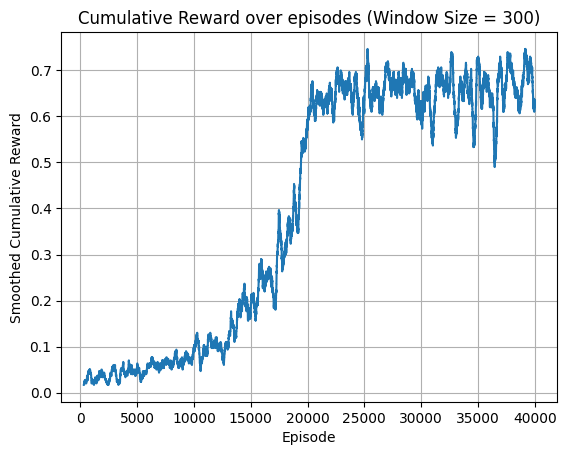

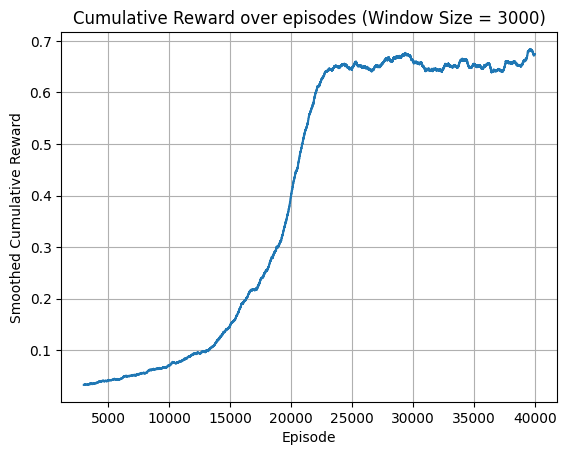

In [175]:
### YOUR CODE HERE
# Some plot stuff
ws = 300
r_sm = np.convolve(G_list, np.ones(ws) / ws, mode='valid')
plt.plot(range(ws, len(G_list) + 1), r_sm)
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.title('Cumulative Reward over episodes (Window Size = {})'.format(ws))
plt.grid(True)
plt.show()

ws = 3000
r_sm = np.convolve(G_list, np.ones(ws) / ws, mode='valid')
plt.plot(range(ws, len(G_list) + 1), r_sm)
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.title('Cumulative Reward over episodes (Window Size = {})'.format(ws))
plt.grid(True)
plt.show()
### END OF YOUR CODE

### 1b. Plot $||Q_k - Q^*||$

Note that use `Q_opt` for $Q^*$. It is given to you in the previous section of this file. You do not need to copy it from HW1.

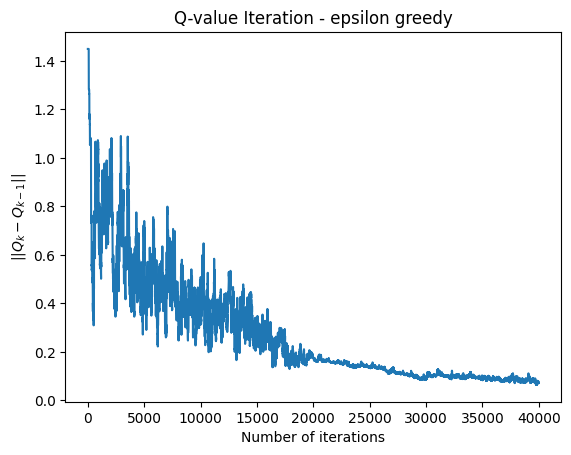

In [167]:
### YOUR CODE HERE
# Some plot stuff
plt.plot(range(len(convergence_list)),convergence_list)
plt.title("Q-value Iteration - epsilon greedy")
plt.xlabel("Number of iterations")
plt.ylabel("$||Q_k - Q_{k-1}||$")
plt.show()
### END OF YOUR CODE

### 1c. Question

What is the policy and Q-value function obtained at the end of the learning? Are you
able to learn the optimal policy? That is, how to get the optimal policy from the optimal Q-value function?

In [130]:
### YOUR CODE HERE
print("Optimal Q-Value using Q Learning")
print(Q)
print("\nQ-Value from HW1")
print(Q_opt)
# Compute the final policy
print("\nOptimal Policy using Q")
optimal_policy_qvi = np.argmax(Q, axis=1)
print(optimal_policy_qvi)
### END OF YOUR CODE

Optimal Q-Value using Q Learning
[[0.0653 0.0636 0.0627 0.0581]
 [0.041  0.0442 0.0403 0.0617]
 [0.0785 0.0731 0.0765 0.0596]
 [0.0426 0.0395 0.0341 0.0589]
 [0.086  0.0648 0.0603 0.0474]
 [0.     0.     0.     0.    ]
 [0.1198 0.0817 0.1048 0.0245]
 [0.     0.     0.     0.    ]
 [0.0611 0.1177 0.1183 0.1393]
 [0.1516 0.2505 0.2121 0.1299]
 [0.3013 0.2727 0.2223 0.1127]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1831 0.3208 0.381  0.2765]
 [0.3928 0.6719 0.6052 0.5218]
 [0.     0.     0.     0.    ]]

Q-Value from HW1
[[0.0689 0.0666 0.0666 0.0597]
 [0.0391 0.043  0.0407 0.0614]
 [0.0744 0.0688 0.0727 0.0575]
 [0.0391 0.0391 0.0335 0.0558]
 [0.0918 0.0712 0.0643 0.0482]
 [0.     0.     0.     0.    ]
 [0.1122 0.0899 0.1122 0.0223]
 [0.     0.     0.     0.    ]
 [0.0712 0.1179 0.1018 0.1454]
 [0.1576 0.2475 0.2039 0.1335]
 [0.2996 0.266  0.2254 0.1079]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1882 0.3057 0.3799 0.266 ]
 [0.3956 0.639  0.

**Write your answer below.**  
Answer:

## 2. Behavior Policy  

Implement tabular Q-learning with a uniformly random policy (where
each action is taken with equal probability) as the behavior policy. Compare the convergence
with the ε-greedy exploration approach. Explain your observations and inference. Can you
implement a better behavior policy and show its effectiveness?

In [166]:
### YOUR CODE HERE
# Freestyle!
no_of_actions = env.action_space.n
no_of_states = env.observation_space.n

max_step = 100
max_episode = 50000

Q_unif = np.zeros((no_of_states, no_of_actions))
G_list_unif = []
convergence_list_unif = []

for k in range(max_episode):
    s0, _ = env.reset()  # start new episode
    path_k = [s0]  # initial state for new episode
    G_k = 0
    for t in range(max_step):
        s_t = path_k[-1] # observe current state s_t
        a_t = np.random.randint(no_of_actions)
        # for a_t in range(no_of_actions):
        ns_t, r_t, terminal, _, _ = env.step(a_t)  # take a step
        ### YOUR CODE HERE
        # TASK 3
        # Hint: you should call lr_decay somewhere here.
        Q_unif[s_t][a_t] = Q_unif[s_t][a_t] + lr_decay(k, max_episode) * (r_t + gamma * np.max(Q_unif[ns_t]) - Q_unif[s_t][a_t])
        ### END OF YOUR CODE
        G_k += r_t
        path_k.append(ns_t)  # record next state
        if terminal:  # next state is a terminal state, episode ended
            break
    convergence_list_unif.append(np.linalg.norm(Q_unif.flatten()-Q_opt.flatten())) # calc and store Euclidean norm of Q_k-Q*
    G_list_unif.append(G_k)

print("Optimal Q-Value using Q Learning")
print(Q_unif)
print("\nQ-Value from HW1")
print(Q_opt)
# Compute the final policy
print("\nUniform Optimal Policy using Q")
print(np.argmax(Q_unif, axis=1))

Optimal Q-Value using Q Learning
[[0.0728 0.0683 0.0701 0.0616]
 [0.0373 0.0436 0.0463 0.0644]
 [0.0796 0.0697 0.0751 0.0622]
 [0.0408 0.0389 0.0354 0.06  ]
 [0.0993 0.0738 0.0707 0.0492]
 [0.     0.     0.     0.    ]
 [0.1139 0.0837 0.0995 0.0213]
 [0.     0.     0.     0.    ]
 [0.0771 0.1137 0.105  0.1546]
 [0.1867 0.259  0.213  0.1266]
 [0.2873 0.258  0.1939 0.1036]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1993 0.3319 0.4305 0.2756]
 [0.4218 0.6677 0.6256 0.5482]
 [0.     0.     0.     0.    ]]

Q-Value from HW1
[[0.0689 0.0666 0.0666 0.0597]
 [0.0391 0.043  0.0407 0.0614]
 [0.0744 0.0688 0.0727 0.0575]
 [0.0391 0.0391 0.0335 0.0558]
 [0.0918 0.0712 0.0643 0.0482]
 [0.     0.     0.     0.    ]
 [0.1122 0.0899 0.1122 0.0223]
 [0.     0.     0.     0.    ]
 [0.0712 0.1179 0.1018 0.1454]
 [0.1576 0.2475 0.2039 0.1335]
 [0.2996 0.266  0.2254 0.1079]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1882 0.3057 0.3799 0.266 ]
 [0.3956 0.639  0.

### Comparision of convergence of $||Q_k - Q_{k-1}||$ and $G_k$ between QVI using epsilon greedy policy and uniform policy

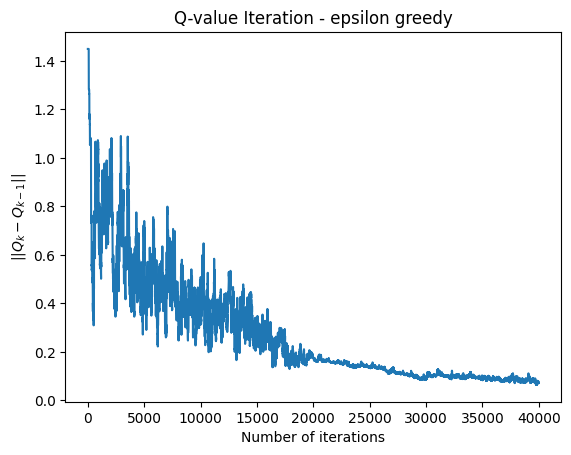

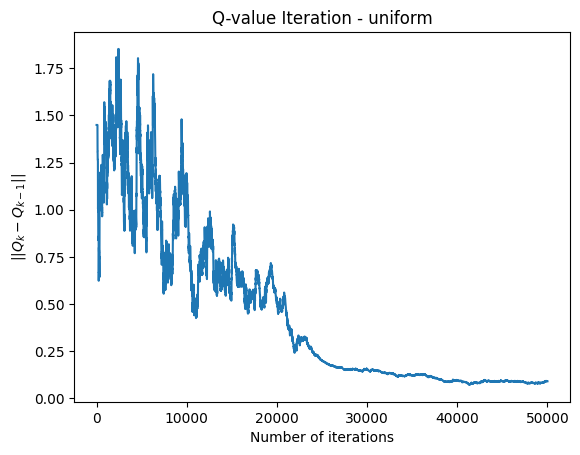

In [169]:
plt.plot(range(len(convergence_list)),convergence_list)
plt.title("Q-value Iteration - epsilon greedy")
plt.xlabel("Number of iterations")
plt.ylabel("$||Q_k - Q_{k-1}||$")
plt.show()

plt.plot(range(len(convergence_list_unif)),convergence_list_unif)
plt.title("Q-value Iteration - uniform")
plt.xlabel("Number of iterations")
plt.ylabel("$||Q_k - Q_{k-1}||$")
plt.show()

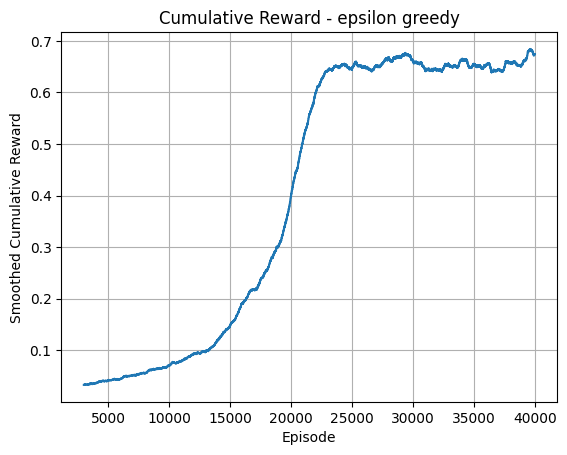

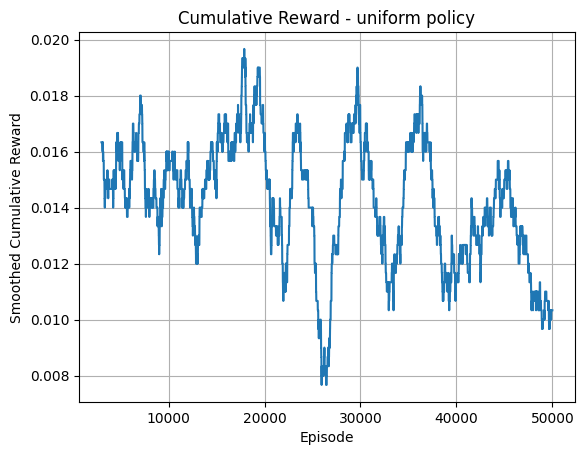

In [170]:
ws = 3000
r_sm = np.convolve(G_list, np.ones(ws) / ws, mode='valid')
plt.plot(range(ws, len(G_list) + 1), r_sm)
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.title('Cumulative Reward - epsilon greedy')
plt.grid(True)
plt.show()

ws = 3000
r_sm = np.convolve(G_list_unif, np.ones(ws) / ws, mode='valid')
plt.plot(range(ws, len(G_list_unif) + 1), r_sm)
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.title('Cumulative Reward - uniform policy')
plt.grid(True)
plt.show()

In [171]:
### Softmax Policy

def softmax(q, tau):
    probabilities = np.exp(q / tau) / np.sum(np.exp(q / tau))
    return probabilities

def softmax_policy(q, tau):
    probabilities = softmax(q, tau)
    return np.random.choice(len(q), p=probabilities)

no_of_actions = env.action_space.n
no_of_states = env.observation_space.n

max_step = 100
max_episode = 50000

Q_sof = np.zeros((no_of_states, no_of_actions))
G_list_sof = []
convergence_list_sof = []

for k in range(max_episode):
    s0, _ = env.reset()  # start new episode
    path_k = [s0]  # initial state for new episode
    G_k = 0
    for t in range(max_step):
        s_t = path_k[-1] # observe current state s_t
        a_t = softmax_policy(Q[s_t], 0.1)
        # for a_t in range(no_of_actions):
        ns_t, r_t, terminal, _, _ = env.step(a_t)  # take a step
        ### YOUR CODE HERE
        # TASK 3
        # Hint: you should call lr_decay somewhere here.
        Q_sof[s_t][a_t] = Q_sof[s_t][a_t] + lr_decay(k, max_episode) * (r_t + gamma * np.max(Q_sof[ns_t]) - Q_sof[s_t][a_t])
        ### END OF YOUR CODE
        G_k += r_t
        path_k.append(ns_t)  # record next state
        if terminal:  # next state is a terminal state, episode ended
            break
    convergence_list_sof.append(np.linalg.norm(Q_sof.flatten()-Q_opt.flatten())) # calc and store Euclidean norm of Q_k-Q*
    G_list_sof.append(G_k)

print("Optimal Q-Value using Q Learning")
print(Q_sof)
print("\nQ-Value from HW1")
print(Q_opt)
# Compute the final policy
print("\nUniform Optimal Policy using Q")
print(np.argmax(Q_sof, axis=1))

Optimal Q-Value using Q Learning
[[0.0684 0.0666 0.0656 0.0595]
 [0.0377 0.0426 0.0345 0.0617]
 [0.075  0.0718 0.0748 0.0597]
 [0.0425 0.0405 0.0337 0.0596]
 [0.0928 0.0791 0.0703 0.0474]
 [0.     0.     0.     0.    ]
 [0.1177 0.0648 0.1082 0.0225]
 [0.     0.     0.     0.    ]
 [0.0707 0.1221 0.1024 0.1513]
 [0.1656 0.2563 0.2149 0.1474]
 [0.3102 0.2702 0.2313 0.1204]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.2218 0.3057 0.392  0.284 ]
 [0.4247 0.6666 0.631  0.5291]
 [0.     0.     0.     0.    ]]

Q-Value from HW1
[[0.0689 0.0666 0.0666 0.0597]
 [0.0391 0.043  0.0407 0.0614]
 [0.0744 0.0688 0.0727 0.0575]
 [0.0391 0.0391 0.0335 0.0558]
 [0.0918 0.0712 0.0643 0.0482]
 [0.     0.     0.     0.    ]
 [0.1122 0.0899 0.1122 0.0223]
 [0.     0.     0.     0.    ]
 [0.0712 0.1179 0.1018 0.1454]
 [0.1576 0.2475 0.2039 0.1335]
 [0.2996 0.266  0.2254 0.1079]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.1882 0.3057 0.3799 0.266 ]
 [0.3956 0.639  0.

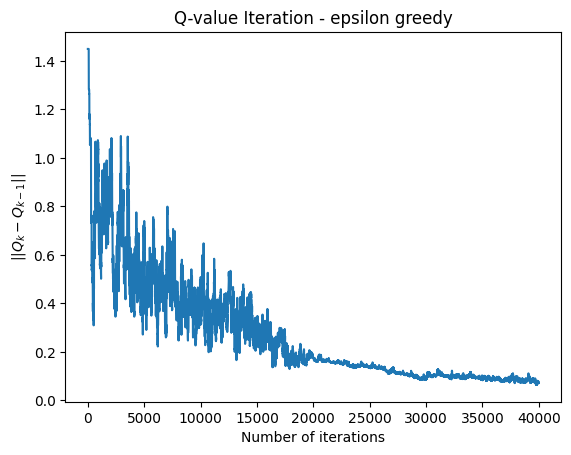

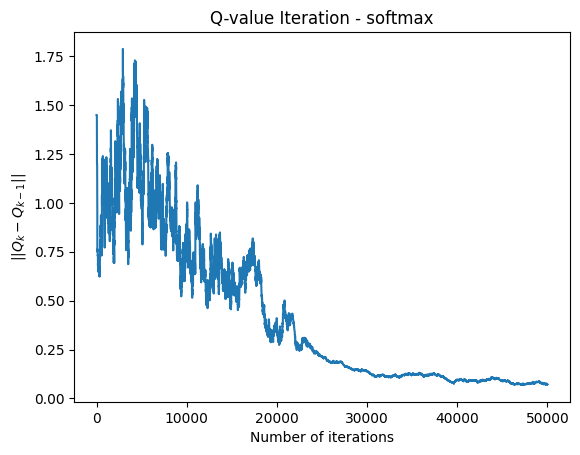

In [172]:
plt.plot(range(len(convergence_list)),convergence_list)
plt.title("Q-value Iteration - epsilon greedy")
plt.xlabel("Number of iterations")
plt.ylabel("$||Q_k - Q_{k-1}||$")
plt.show()

plt.plot(range(len(convergence_list_sof)),convergence_list_sof)
plt.title("Q-value Iteration - softmax")
plt.xlabel("Number of iterations")
plt.ylabel("$||Q_k - Q_{k-1}||$")
plt.show()

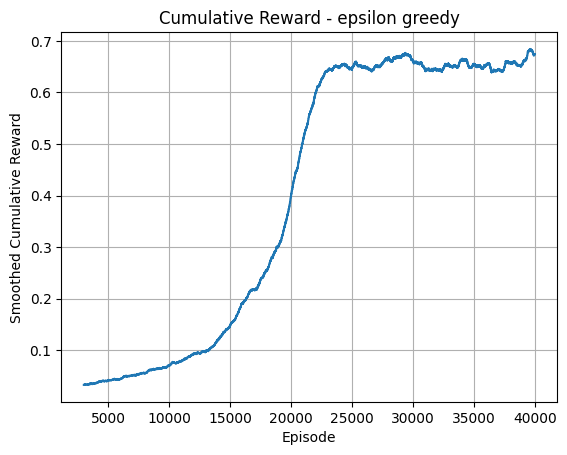

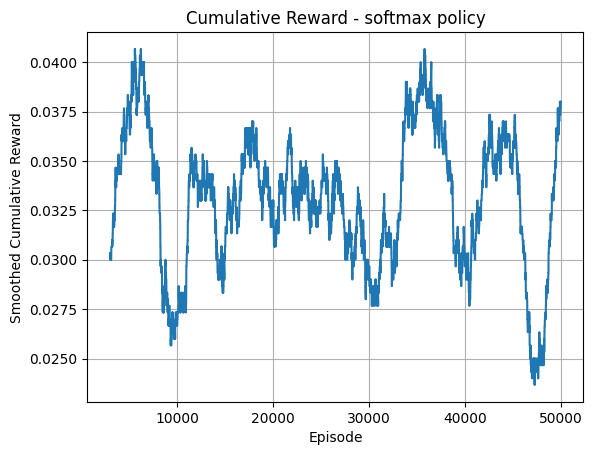

In [173]:
ws = 3000
r_sm = np.convolve(G_list, np.ones(ws) / ws, mode='valid')
plt.plot(range(ws, len(G_list) + 1), r_sm)
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.title('Cumulative Reward - epsilon greedy')
plt.grid(True)
plt.show()

ws = 3000
r_sm = np.convolve(G_list_sof, np.ones(ws) / ws, mode='valid')
plt.plot(range(ws, len(G_list_sof) + 1), r_sm)
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.title('Cumulative Reward - softmax policy')
plt.grid(True)
plt.show()

**Write your answer below.**  
Answer: Based on above graphs, these are the comparisions:

**Observations**:

Convergence Rate: The ε-greedy approach converges faster than a random policy. This is evident from the graph, where the ε-greedy line drops more steeply than the random policy line.

**Inferences**:

Exploration-Exploitation Trade-off: The ε-greedy approach balances exploration (trying unexplored actions with probability ε) and exploitation (choosing the current best-known action with probability 1-ε). This leads to faster convergence compared to the random policy, which does not exploit the gathered knowledge.

Optimal Policy: The ε-greedy approach is more likely to lead to the optimal Q-values and policy. While the random policy explores the state-action space, it does not exploit the knowledge the agent has acquired about which actions are better in certain states. As a result, it may not converge to the optimal policy.

Sub-optimal Policy: A greedy-only policy, although it may converge faster, can lead to a sub-optimal policy. This suggests that balancing exploration and exploitation, as done in the ε-greedy approach, is crucial for achieving optimal results.

Overall, the ε-greedy approach demonstrates the importance of balancing exploration and exploitation in reinforcement learning, leading to faster convergence and potentially optimal policies. However, it's essential to consider the specific problem domain and characteristics when choosing an exploration strategy.

## 3. TD-Learning

Consider the following polices: (i) the optimal policy obtained from QVI,
and (ii) a uniformly random policy where each action is taken with equal probability. Learn
the value of the these polices using:

### 3a. Monte Carlo (MC) Learning

In [128]:
### YOUR CODE HERE
# Freestyle!
no_of_actions = env.action_space.n
no_of_states = env.observation_space.n
max_episodes = 50000
max_steps = 200
pi = np.argmax(Q_opt, axis=1)

### MC using optimal policy 
V_opt = np.zeros(no_of_states)  # Value of policy using optimal policy
sc = [0]*no_of_states   # State visit count

for k in range(max_episodes):
    s_t, _ = env.reset()
    terminate = False   # Track episode end
    step_count = 1
    sr_p = []   # Store state and respective reward

    # Run Episode
    while not terminate and step_count < max_steps:
        a_t = pi[s_t]
        n_t, r_t, terminate, _, _ = env.step(a_t)
        sr_p.append([s_t, r_t])
        step_count += 1
        s_t = n_t

    # Compute G for each state visit and update V
    G = 0
    for i in range(len(sr_p)-1, -1, -1):
        s_t, r_t = sr_p[i]
        G = r_t + gamma * G
        sc[s_t] += 1    # No of times state s_t is visited in trajectory
        alpha = 1/sc[s_t]
        V_opt[s_t] += alpha * (G - V_opt[s_t])

### MC using uniform policy
V_unif = np.zeros(no_of_states)  # Value of policy using uniform policy
sc = [0]*no_of_states   # State visit count

for k in range(max_episodes):
    s_t, _ = env.reset()
    terminate = False   # Track episode end
    step_count = 1
    sr_p = []   # Store state and respective reward

    # Run Episode
    while not terminate:
        a_t = np.random.randint(no_of_actions)
        n_t, r_t, terminate, _, _ = env.step(a_t)
        sr_p.append([s_t, r_t])
        step_count += 1
        s_t = n_t

    # Compute G for each state visit and update V
    G = 0
    for i in range(len(sr_p)-1, -1, -1):
        s_t, r_t = sr_p[i]
        G = r_t + gamma * G
        sc[s_t] += 1    # No of times state s_t is visited in trajectory
        alpha = 1/sc[s_t]
        V_unif[s_t] += alpha * (G - V_unif[s_t])

print('MC Policy evaluation for optimal policy')
print(V_opt, '\n')
print('MC Policy evaluation for uniform policy')
print(V_unif)
### END OF YOUR CODE

MC Policy evaluation for optimal policy
[0.0692 0.0615 0.0733 0.     0.0921 0.     0.1083 0.     0.1453 0.2466
 0.2953 0.     0.     0.3811 0.6383 0.    ] 

MC Policy evaluation for uniform policy
[0.0041 0.0042 0.0092 0.0037 0.0064 0.     0.0264 0.     0.0161 0.0511
 0.1032 0.     0.     0.124  0.376  0.    ]


### 3b. Temporal Difference (TD) Learning

In [164]:
### YOUR CODE HERE
# Freestyle!
no_of_actions = env.action_space.n
no_of_states = env.observation_space.n
max_episodes = 40000
max_steps = 100

V = np.zeros(no_of_states)

for k in range(max_episodes):
    s_t, _ = env.reset()
    terminate = False   # Track episode end
    step_count = 1

    # Run Episode
    while not terminate and step_count < max_steps:
        # print(s_t)
        a_t = optimal_policy_qvi[s_t]
        n_t, r_t, terminate, _, _ = env.step(a_t)
        step_count += 1
        td_target = r_t + gamma * V[n_t] if not terminate else r_t  # TD target
        td_error = td_target - V[s_t]

        ### TEST alpha IMPPPPPPPPPPPPP (alpha = 0.1, 0.5, etc..)
        V[s_t] += lr_decay(k) * td_error
        s_t = n_t

print("TD Policy evaluation for optimal policy")
print(V, "\n")

V = np.zeros(no_of_states)

for k in range(max_episodes):
    s_t, _ = env.reset()
    terminate = False   # Track episode end
    step_count = 1

    # Run Episode
    while not terminate and step_count < max_steps:
        # print(s_t)
        a_t = np.random.randint(no_of_actions)
        n_t, r_t, terminate, _, _ = env.step(a_t)
        step_count += 1
        td_target = r_t + gamma * V[n_t] if not terminate else r_t  # TD target
        td_error = td_target - V[s_t]

        ### TEST alpha IMPPPPPPPPPPPPP (alpha = 0.1, 0.5, etc..)
        V[s_t] += lr_decay(k) * td_error
        s_t = n_t

print("TD Policy evaluation for uniform policy")
print(V)
### END OF YOUR CODE

TD Policy evaluation for optimal policy
[0.0698 0.0597 0.071  0.     0.0986 0.     0.1094 0.     0.1547 0.2463
 0.3153 0.     0.     0.3948 0.6627 0.    ] 

TD Policy evaluation for uniform policy
[0.0043 0.0043 0.0096 0.0044 0.0061 0.     0.0282 0.     0.0191 0.0586
 0.1027 0.     0.     0.1393 0.3708 0.    ]


### 3c. What are the trade-offs of between MC vs TD?

**Write your answer below.**  
Answer: The trade-offs between TD and MC learning in RL:

1. TD learning's step-by-step update enables faster learning but introduces bias due to reliance on existing value estimates, while MC learning's episodic update provides unbiased estimates but delays learning until the episode concludes, making it less suitable for very long or continuous tasks.

2. TD learning method offer quicker and more stable convergence at the cost of some bias in the estimates, while MC learning method provide more accurate value estimates in the long run because of lower bias but can suffer from high variance in the short term.

3. TD learning's incremental learning approach offers greater efficiency and flexibility in a wider range of environments, including those without a clear endpoint. MC learning's reliance on complete episodes limits its applicability to tasks with clearly defined ends.

4. TD learning method, by exploiting the Markov property, can learn more efficiently in environments where this property holds, but might be less effective when it doesn't, while MC learning method can be applied more broadly, including in environments where the Markov property doesn't strictly apply, offering greater flexibility.

̌The choice between TD and MC methods depends on the requirements of the problem you are solving, including the nature of the task (episodic vs. continuous), the applicability of the Markov property and the acceptable balance between variance and bias.